C:\Users\пользователь\AppData\Local\Temp\ipykernel_24780\1646303511.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema_values = [prices[0]]  # Pierwsza wartość EMA to pierwsza cena
C:\Users\пользователь\AppData\Local\Temp\ipykernel_24780\1646303511.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema_values = [prices[0]]  # Pierwsza wartość EMA to pierwsza cena
C:\Users\пользователь\AppData\Local\Temp\ipykernel_24780\1646303511.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

Końcowy kapitał inwestora: 14166.2
Liczba transakcji: 64
Liczba transakcji zyskownych: 56
Liczba transakcji stratnych: 8
Skuteczność strategii: 87.50%


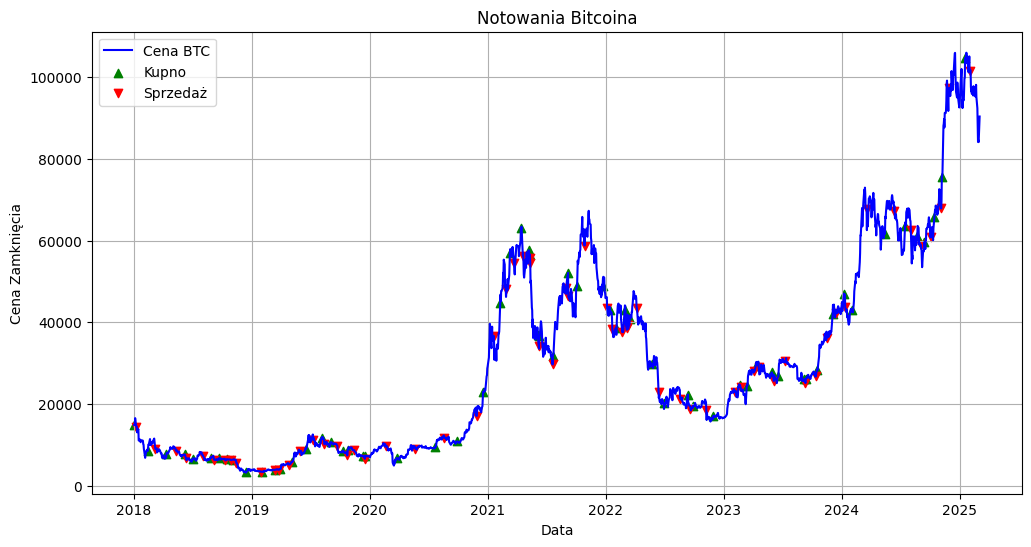

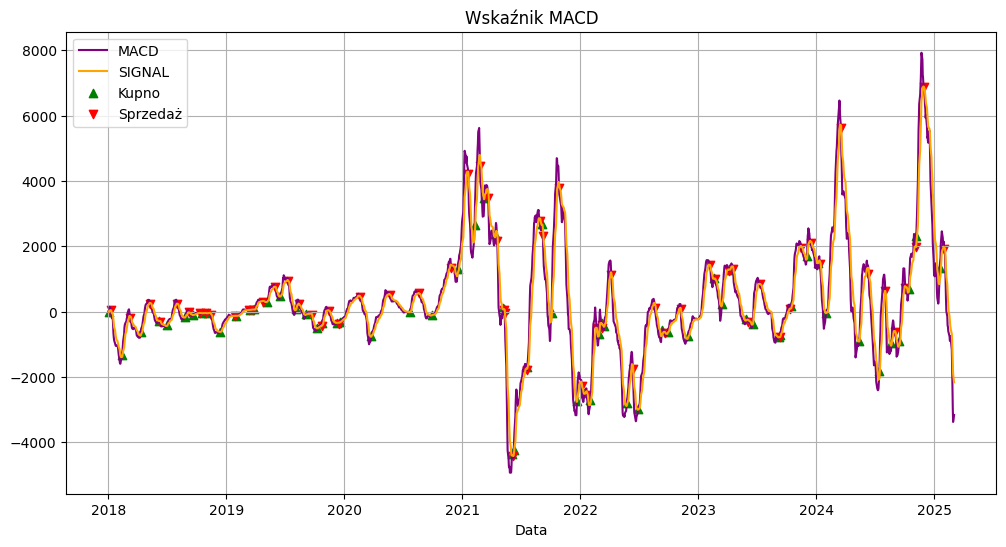

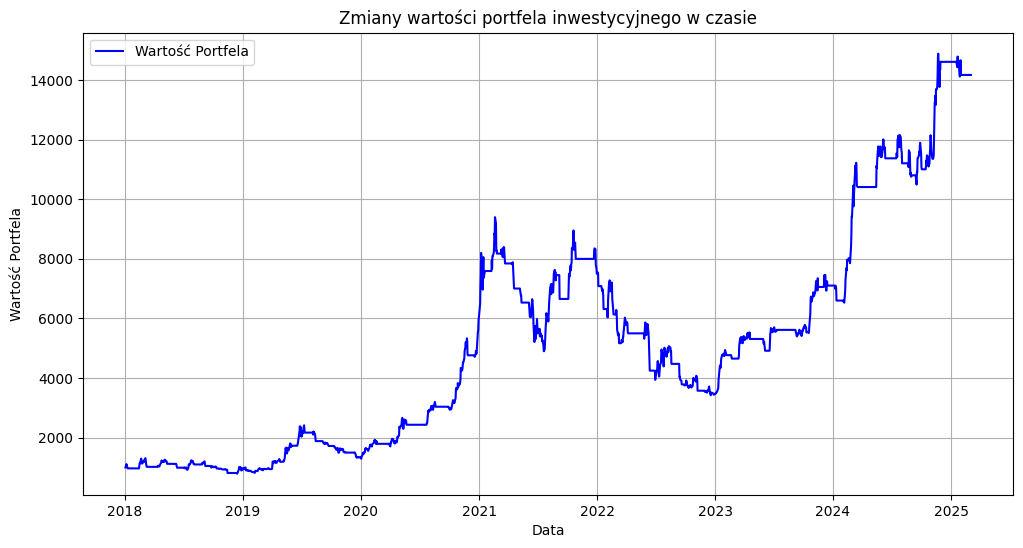

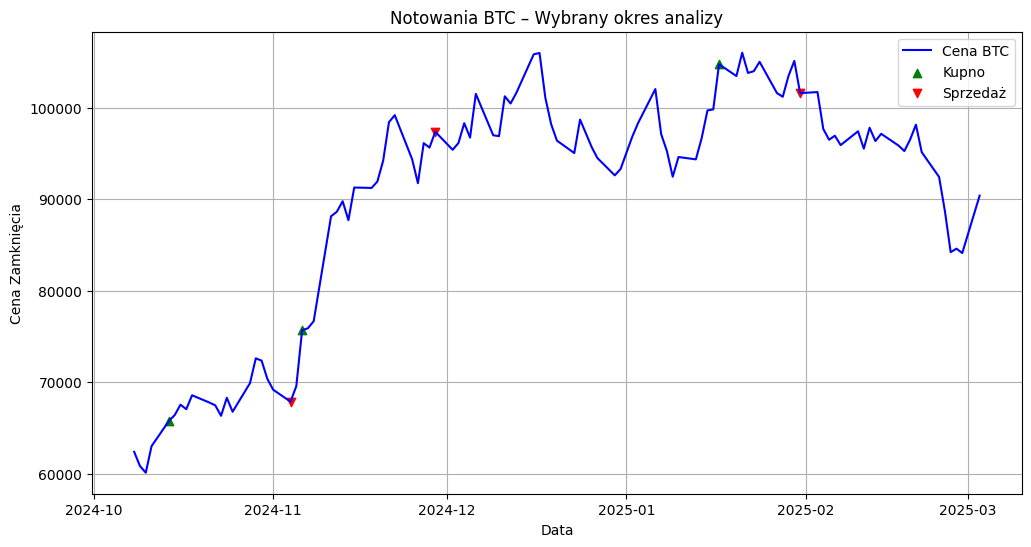

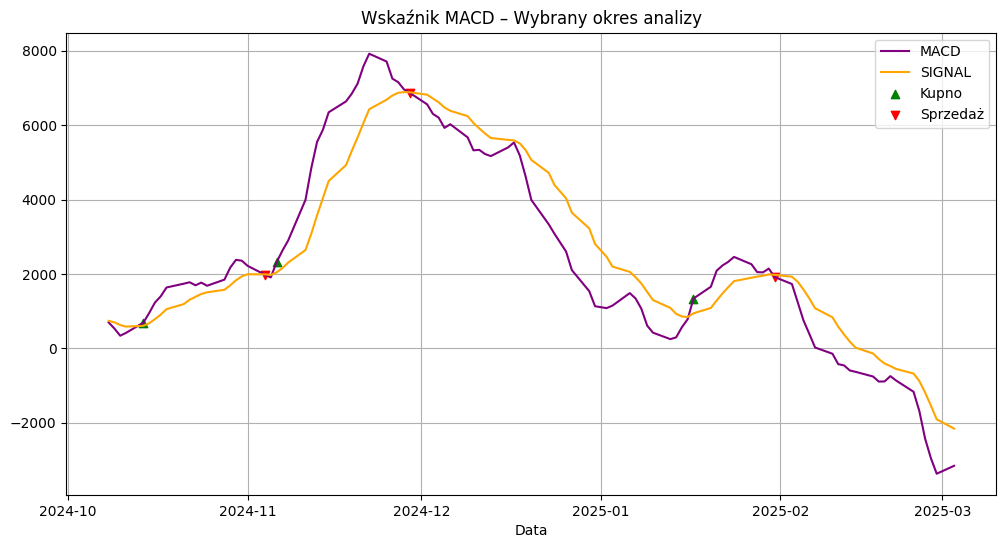

Analiza transakcji:
Transakcja 1: KUPNO: 2024-10-14 za 65777.70 | SPRZEDAŻ: 2024-11-04 za 67885.40 | Zysk/Strata: 2107.70
Transakcja 2: KUPNO: 2024-11-06 za 75684.10 | SPRZEDAŻ: 2024-11-29 za 97373.80 | Zysk/Strata: 21689.70
Transakcja 3: KUPNO: 2025-01-17 za 104748.00 | SPRZEDAŻ: 2025-01-31 za 101597.00 | Zysk/Strata: -3151.00

SUMARYCZNY WYNIK: 20646.40


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Wczytanie danych
df = pd.read_csv("btcusd_d.csv")
df["Data"] = pd.to_datetime(df["Data"])  # Konwersja daty na format datetime
df.set_index("Data", inplace=True)  # Ustawienie indeksu na datę

# 2. Funkcja do obliczania EMA
def calculate_ema(prices, period):
    alpha = 2 / (period + 1)
    ema_values = [prices[0]]  # Pierwsza wartość EMA to pierwsza cena
    for price in prices[1:]:
        ema_values.append(alpha * price + (1 - alpha) * ema_values[-1])
    return np.array(ema_values)

# 3. Obliczenie EMA 12, EMA 26, MACD i SIGNAL
df["EMA12"] = calculate_ema(df["Zamkniecie"], 12)
df["EMA26"] = calculate_ema(df["Zamkniecie"], 26)
df["MACD"] = df["EMA12"] - df["EMA26"]
df["SIGNAL"] = calculate_ema(df["MACD"], 9)

# 4. Znalezienie punktów kupna i sprzedaży
df["Buy_Signal"] = (df["MACD"] > df["SIGNAL"]) & (df["MACD"].shift(1) <= df["SIGNAL"].shift(1))
df["Sell_Signal"] = (df["MACD"] < df["SIGNAL"]) & (df["MACD"].shift(1) >= df["SIGNAL"].shift(1))

# 5. Symulacja strategii MACD
initial_cash = 1000  # Początkowy kapitał w USDT
cash = initial_cash  # Aktualna ilość gotówki
btc = 0  # Liczba posiadanych BTC
portfolio_value = []  # Historia wartości portfela
transactions = []  # Lista przeprowadzonych transakcji

for i in range(len(df)):
    price = df["Zamkniecie"].iloc[i]  # Aktualna cena BTC
    if df["Buy_Signal"].iloc[i] and cash > 0:
        btc = cash / price  # Kupujemy maksymalną możliwą ilość BTC
        cash = 0  # Wydaliśmy całą gotówkę
        transactions.append({"Type": "BUY", "Date": df.index[i], "Price": price, "BTC": btc})
    elif df["Sell_Signal"].iloc[i] and btc > 0:
        cash = btc * price  # Sprzedajemy wszystkie BTC
        profit = cash - initial_cash  # Zysk/strata z transakcji
        transactions.append({"Type": "SELL", "Date": df.index[i], "Price": price, "Profit": profit})
        btc = 0  # Nie mamy już BTC

    # Obliczamy wartość portfela
    portfolio_value.append(cash + btc * price)

# 6. Podsumowanie wyników
total_profit = cash + btc * df["Zamkniecie"].iloc[-1] - initial_cash
winning_trades = sum(1 for t in transactions if t["Type"] == "SELL" and t["Profit"] > 0)
losing_trades = sum(1 for t in transactions if t["Type"] == "SELL" and t["Profit"] <= 0)
total_trades = winning_trades + losing_trades
win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
7
print("Końcowy kapitał inwestora:", round(total_profit + initial_cash, 2))
print("Liczba transakcji:", total_trades)
print("Liczba transakcji zyskownych:", winning_trades)
print("Liczba transakcji stratnych:", losing_trades)
print(f"Skuteczność strategii: {win_rate:.2f}%")

# 7. Wykresy
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Zamkniecie"], label="Cena BTC", color="blue")
plt.scatter(df.index[df["Buy_Signal"]], df["Zamkniecie"][df["Buy_Signal"]], marker="^", color="green", label="Kupno")
plt.scatter(df.index[df["Sell_Signal"]], df["Zamkniecie"][df["Sell_Signal"]], marker="v", color="red", label="Sprzedaż")
plt.legend()
plt.title("Notowania Bitcoina")
plt.xlabel("Data")
plt.ylabel("Cena Zamknięcia")
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["MACD"], label="MACD", color="purple")
plt.plot(df.index, df["SIGNAL"], label="SIGNAL", color="orange")
plt.scatter(df.index[df["Buy_Signal"]], df["MACD"][df["Buy_Signal"]], marker="^", color="green", label="Kupno")
plt.scatter(df.index[df["Sell_Signal"]], df["MACD"][df["Sell_Signal"]], marker="v", color="red", label="Sprzedaż")
plt.legend()
plt.title("Wskaźnik MACD")
plt.xlabel("Data")
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, portfolio_value, label="Wartość Portfela", color="blue")
plt.xlabel("Data")
plt.ylabel("Wartość Portfela")
plt.title("Zmiany wartości portfela inwestycyjnego w czasie")
plt.grid()
plt.legend()
plt.show()


df_selected = df.iloc[1750:]

plt.figure(figsize=(12, 6))
plt.plot(df_selected.index, df_selected["Zamkniecie"], label="Cena BTC", color="blue")
plt.scatter(df_selected.index[df_selected["Buy_Signal"]], df_selected["Zamkniecie"][df_selected["Buy_Signal"]], marker="^", color="green", label="Kupno")
plt.scatter(df_selected.index[df_selected["Sell_Signal"]], df_selected["Zamkniecie"][df_selected["Sell_Signal"]], marker="v", color="red", label="Sprzedaż")
plt.legend()
plt.title("Notowania BTC – Wybrany okres analizy")
plt.xlabel("Data")
plt.ylabel("Cena Zamknięcia")
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_selected.index, df_selected["MACD"], label="MACD", color="purple")
plt.plot(df_selected.index, df_selected["SIGNAL"], label="SIGNAL", color="orange")
plt.scatter(df_selected.index[df_selected["Buy_Signal"]], df_selected["MACD"][df_selected["Buy_Signal"]], marker="^", color="green", label="Kupno")
plt.scatter(df_selected.index[df_selected["Sell_Signal"]], df_selected["MACD"][df_selected["Sell_Signal"]], marker="v", color="red", label="Sprzedaż")
plt.legend()
plt.title("Wskaźnik MACD – Wybrany okres analizy")
plt.xlabel("Data")
plt.grid()
plt.show()

# Tworzenie listy transakcji kupna i sprzedaży
transactions = []
buy_price = None

for date, row in df_selected.iterrows():
    if row["Buy_Signal"]:
        buy_price = row["Zamkniecie"]
        buy_date = date
    elif row["Sell_Signal"] and buy_price is not None:
        sell_price = row["Zamkniecie"]
        sell_date = date
        profit = sell_price - buy_price
        transactions.append((buy_date, buy_price, sell_date, sell_price, profit))
        buy_price = None  # Reset dla kolejnej transakcji

# Wyświetlenie wyników
print("Analiza transakcji:")
for i, (buy_date, buy_price, sell_date, sell_price, profit) in enumerate(transactions):
    print(f"Transakcja {i+1}: KUPNO: {buy_date.date()} za {buy_price:.2f} | SPRZEDAŻ: {sell_date.date()} za {sell_price:.2f} | Zysk/Strata: {profit:.2f}")

# Obliczenie sumarycznego zysku lub straty
total_profit = sum([t[4] for t in transactions])
print(f"\nSUMARYCZNY WYNIK: {total_profit:.2f}")